In [51]:
# Import dependencies 
import pandas as pd
import numpy as np
import random
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt


In [52]:
# Load the news_articles.csv into a DataFrame.
stock_data_df = pd.read_csv('Resources/stock_yfinance_data.csv')
tweet_data_df = pd.read_csv('Resources/stock_tweets.csv')


In [53]:
# Display the stock data 
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
filtered_stock_data_df = stock_data_df[stock_data_df['Stock Name'].isin(stock_names_of_interest)]
filtered_stock_data_df =filtered_stock_data_df.drop(columns=['High', 'Low', 'Adj Close', 'Volume'])
filtered_stock_data_df['Price Change'] =filtered_stock_data_df['Close'] - filtered_stock_data_df['Open']
filtered_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Open', 'Close', 'Price Change']]

filtered_stock_data_df


,Date,Stock Name,Open,Close,Price Change
0,2021-09-30,TSLA,260.333344,258.493347,-1.839996
1,2021-10-01,TSLA,259.466675,258.406677,-1.059998
2,2021-10-04,TSLA,265.500000,260.510010,-4.989990
3,2021-10-05,TSLA,261.600006,260.196655,-1.403351
4,2021-10-06,TSLA,258.733337,260.916656,2.183319
...,...,...,...,...,...
1255,2022-09-23,AMZN,116.000000,113.779999,-2.220001
1256,2022-09-26,AMZN,113.300003,115.150002,1.849998
1257,2022-09-27,AMZN,117.199997,114.410004,-2.789993
1258,2022-09-28,AMZN,114.379997,118.010002,3.630005


In [54]:
filtered_stock_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1260 entries, 0 to 1259
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1260 non-null   object 
 1   Stock Name    1260 non-null   object 
 2   Open          1260 non-null   float64
 3   Close         1260 non-null   float64
 4   Price Change  1260 non-null   float64
dtypes: float64(3), object(2)
memory usage: 59.1+ KB


In [55]:
# Define the specific date range
# start_date = '2022-02-01'
# end_date = '2022-02-28'

# filtered_stock_data_df = filtered_stock_data_df[(filtered_stock_data_df['Date'] >= start_date) & (filtered_stock_data_df['Date'] <= end_date)]

# for stock_name in stock_names_of_interest:
    # Filter the DataFrame for the current stock
#     stock_df = filtered_stock_data_df[filtered_stock_data_df['Stock Name'] == stock_name]
    
    # Plot the stock data
#     plt.figure(figsize=(10, 5))
#     plt.plot(stock_df['Date'], stock_df['Close'], label=stock_name)
#     plt.title(f'Stock Data for {stock_name}')
#     plt.xlabel('Date')
#     plt.xticks(rotation=45)
#     plt.ylabel('Price')
#     plt.legend()
#     plt.show()

In [56]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [57]:
# Display the tweet data
tweet_data_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [58]:
# Convert the 'Date' column to a datetime object
tweet_data_df['Date'] = pd.to_datetime(tweet_data_df['Date'])
tweet_data_df['Date'] = tweet_data_df['Date'].dt.date

# Filter the DataFrame to only include the specified stocks
tweets_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']
filtered_tweet_data_df = tweet_data_df[tweet_data_df['Stock Name'].isin(tweets_of_interest)]
filtered_tweet_data_df = filtered_tweet_data_df[['Date', 'Stock Name', 'Tweet']]

filtered_tweet_data_df

,Date,Stock Name,Tweet
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...


In [59]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = filtered_tweet_data_df["Tweet"]

# Function to analyze sentiment of each sentence
def analyze_sentiment(sentences):
    return analyzer.polarity_scores(sentences)

# Apply the sentiment analysis to each tweet and create new columns
filtered_tweet_data_df[['neg', 'neu', 'pos', 'compound']] = filtered_tweet_data_df['Tweet'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# filtered_tweet_data_df = filtered_tweet_data_df.drop(columns=['sentiment_scores'])

filtered_tweet_data_df.head(20)

,Date,Stock Name,Tweet,neg,neu,pos,compound
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...,0.125,0.763,0.113,0.0772
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...,0.000,1.000,0.000,0.0000
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...,0.000,0.954,0.046,0.2960
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.273,0.590,0.137,-0.7568
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.526,0.474,0.000,-0.8750
5,2022-09-29,TSLA,@RealDanODowd @Tesla This is you https://t.co/...,0.000,1.000,0.000,0.0000
6,2022-09-29,TSLA,For years @WholeMarsBlog viciously silenced @T...,0.298,0.662,0.041,-0.9359
7,2022-09-29,TSLA,$NIO just because I'm down money doesn't mean ...,0.155,0.690,0.155,0.2500
8,2022-09-29,TSLA,50 likes for some $SPY $TSLA charts to study!\...,0.000,0.764,0.236,0.4753
9,2022-09-29,TSLA,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,0.272,0.728,0.000,-0.8625


In [60]:
# Function to normalize sentiment based on the thresholds
def normalize_sentiment(compound):
    if compound >= 0.05:
        return 1  # Positive sentiment normalized to 1
    elif -0.05 < compound < 0.05:
        return 0  # Neutral sentiment normalized to 0
    elif compound <= -0.05:
        return -1  # Negative sentiment normalized to -1

# Apply the normalization function to the 'compound_score' column
filtered_tweet_data_df['normalized_sentiment'] = filtered_tweet_data_df['compound'].apply(normalize_sentiment)

# Display the DataFrame with the normalized sentiment
filtered_tweet_data_df.head(20)

,Date,Stock Name,Tweet,neg,neu,pos,compound,normalized_sentiment
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...,0.125,0.763,0.113,0.0772,1
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...,0.000,1.000,0.000,0.0000,0
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...,0.000,0.954,0.046,0.2960,1
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.273,0.590,0.137,-0.7568,-1
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.526,0.474,0.000,-0.8750,-1
5,2022-09-29,TSLA,@RealDanODowd @Tesla This is you https://t.co/...,0.000,1.000,0.000,0.0000,0
6,2022-09-29,TSLA,For years @WholeMarsBlog viciously silenced @T...,0.298,0.662,0.041,-0.9359,-1
7,2022-09-29,TSLA,$NIO just because I'm down money doesn't mean ...,0.155,0.690,0.155,0.2500,1
8,2022-09-29,TSLA,50 likes for some $SPY $TSLA charts to study!\...,0.000,0.764,0.236,0.4753,1
9,2022-09-29,TSLA,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,0.272,0.728,0.000,-0.8625,-1


In [61]:
mean_score_df = filtered_tweet_data_df.groupby(['Date', 'Stock Name'])['compound'].mean()
print(mean_score_df)  # Check the structure of the result here


Date        Stock Name
2021-09-30  AMZN          0.256980
            META          0.472467
            MSFT          0.256980
            PG            0.256980
            TSLA          0.251634
                            ...   
2022-09-29  AMZN          0.086080
            META         -0.051600
            MSFT          0.086080
            PG            0.086080
            TSLA          0.057709
Name: compound, Length: 1768, dtype: float64


In [62]:
mean_score_df = mean_score_df.reset_index()
# print(mean_score_df)  # Check the structure of the result after resetting the index

mean_score_df

,Date,Stock Name,compound
0,2021-09-30,AMZN,0.256980
1,2021-09-30,META,0.472467
2,2021-09-30,MSFT,0.256980
3,2021-09-30,PG,0.256980
4,2021-09-30,TSLA,0.251634
...,...,...,...
1763,2022-09-29,AMZN,0.086080
1764,2022-09-29,META,-0.051600
1765,2022-09-29,MSFT,0.086080
1766,2022-09-29,PG,0.086080


In [63]:
# mean_score_df = filtered_tweet_data_df.groupby(['Date', 'Stock Name'])['compound'].mean()
# mean_score_df = mean_score_df.reset_index()  # Reset the index
# mean_score_df.set_index(['Stock Name', 'compound'], inplace=True)  # Set new index
# print(mean_score_df)


In [64]:
mean_score_df.set_index('Date')
mean_score_df.columns




Index(['Date', 'Stock Name', 'compound'], dtype='object')

In [65]:

filtered_stock_data_df.loc[:, 'Date'] = pd.to_datetime(filtered_stock_data_df['Date'])
mean_score_df.loc[:, 'Date'] = pd.to_datetime(mean_score_df['Date'])

new_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Open', 'Close', 'Price Change']]
new_tweet_data_df = mean_score_df[['Date', 'Stock Name', 'compound']]
merged_df = pd.merge(new_stock_data_df, new_tweet_data_df, on=['Date', 'Stock Name'], how='inner')
# merged_df.set_index('Date', inplace=True)

merged_df.head()


,Date,Stock Name,Open,Close,Price Change,compound
0,2021-09-30 00:00:00,TSLA,260.333344,258.493347,-1.839996,0.251634
1,2021-10-01 00:00:00,TSLA,259.466675,258.406677,-1.059998,0.222412
2,2021-10-04 00:00:00,TSLA,265.500000,260.510010,-4.989990,0.151775
3,2021-10-05 00:00:00,TSLA,261.600006,260.196655,-1.403351,0.096692
4,2021-10-06 00:00:00,TSLA,258.733337,260.916656,2.183319,0.229846


In [68]:
from sklearn.preprocessing import StandardScaler

# Assuming merged_df contains the 'compound' sentiment scores and 'Price Change' columns
scaler = StandardScaler()

# Select the columns to be scaled
merged_df[['compound', 'Price Change']] = scaler.fit_transform(merged_df[['compound', 'Price Change']])

# Now the 'compound' and 'Price Change' columns are standardized
print(merged_df.head())

         Date Stock Name        Open       Close  Price Change  compound
65 2022-01-03       TSLA  382.583344  399.926666      2.502369 -0.334314
66 2022-01-04       TSLA  396.516663  383.196655     -1.854209 -0.732775
67 2022-01-05       TSLA  382.216675  362.706665     -2.733670 -0.354045
68 2022-01-06       TSLA  359.000000  354.899994     -0.544251 -0.446237
69 2022-01-07       TSLA  360.123322  342.320007     -2.491187 -0.694032


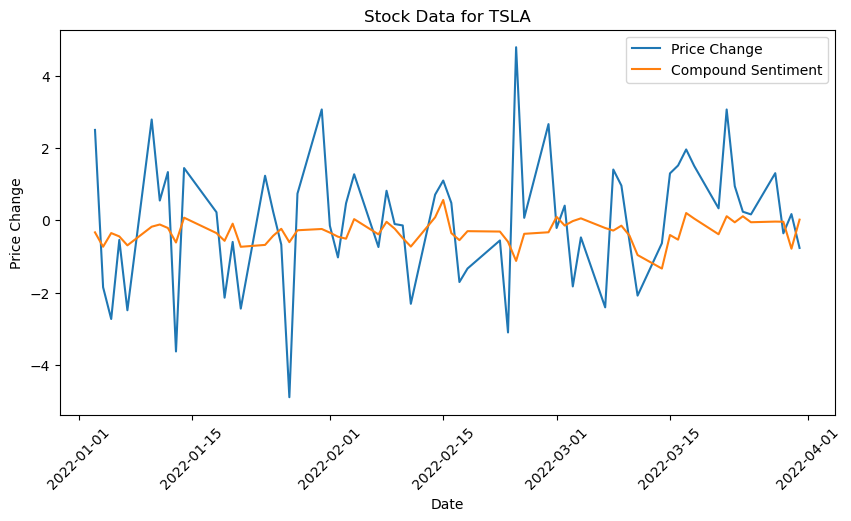

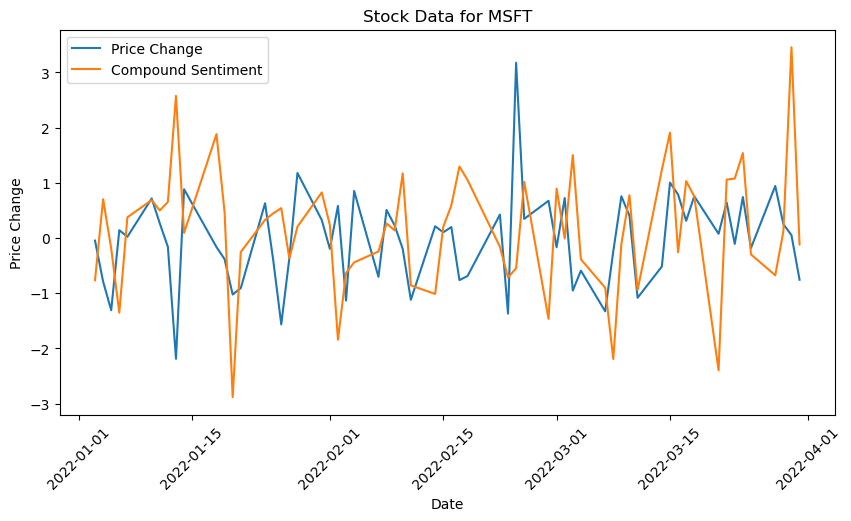

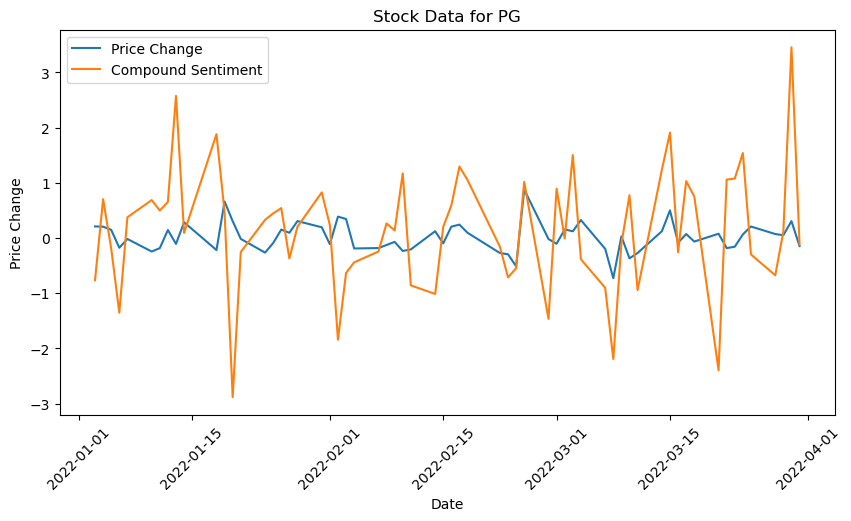

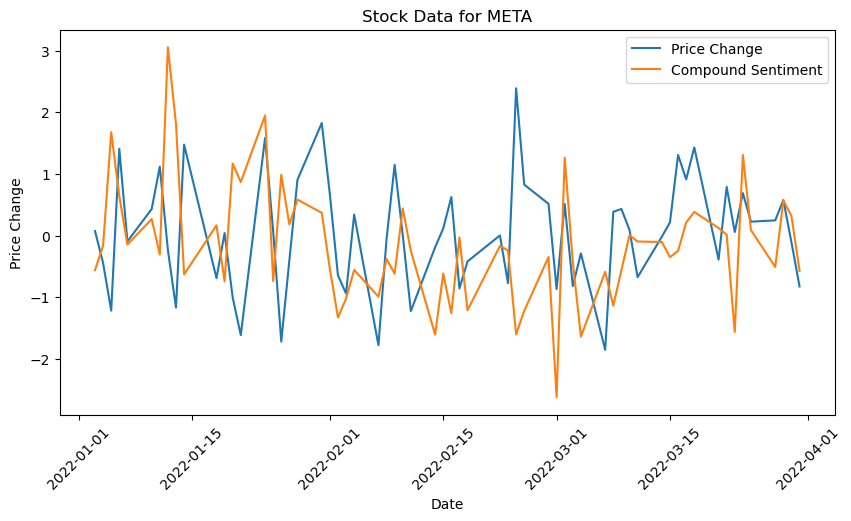

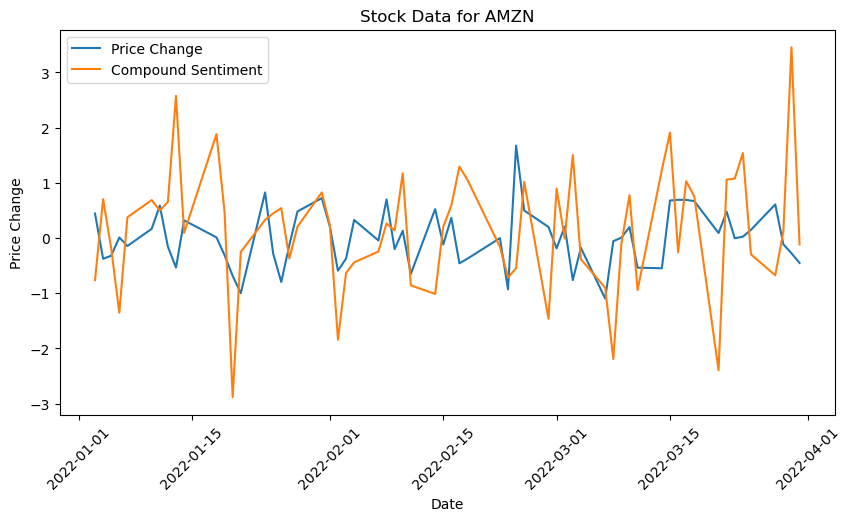

In [70]:
# Define the specific date range
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
start_date = '2022-01-01'
end_date = '2022-03-31'

merged_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]

for stock_name in stock_names_of_interest:
    # Filter the DataFrame for the current stock
    stock_df = merged_df[merged_df['Stock Name'] == stock_name]
    
    # Plot the stock data
    plt.figure(figsize=(10, 5))
    plt.plot(stock_df['Date'], stock_df[['Price Change', 'compound']], label=stock_name)
    plt.title(f'Stock Data for {stock_name}')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Price Change')
    plt.legend(['Price Change', 'Compound Sentiment'])
    plt.show()

In [67]:
merged_df.to_csv('merged_data.csv', index=True)